## CSE 574 Planing and Learning Methods in AI (Fall 2023)

# Assignment 1: Part 2

## Multi-Objective Bayesian Optimization

### 1. Getting to know software libraries

In [1]:
# Install BoTorch
!pip install botorch

In [2]:
# Import functions that you might need to use
import numpy as np
import matplotlib.pyplot as plt
import torch
from botorch.models import SingleTaskGP, ModelListGP
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model
from botorch.optim.optimize import optimize_acqf
from botorch.utils.transforms import unnormalize, normalize
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.sampling.normal import SobolQMCNormalSampler
import warnings
warnings.filterwarnings("ignore")

In this assignment, we minimize two objective functions using Bayesian Optimization.

The first objective function $f_1$ is the neural network with weights loaded from "net_f1.pth".

The second objective function $f_2$ is the neural network with weights loaded from "net_f2.pth".

You should perform the optimization with respect to $x$ within the range of $[-1,1]$.

In [3]:
# Declare the bound and define the functions of f1 and f2. You can use f1 and f2 defined below.
import torch.nn as nn
class Approximator(nn.Module):
    def __init__(self):
        super(Approximator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

net_f1 = Approximator()
net_f2 = Approximator()
net_f1 = torch.load('net_f1.pth', map_location=torch.device('cpu'))
net_f2 = torch.load('net_f2.pth', map_location=torch.device('cpu'))

def f1(x):
    y = net_f1(torch.FloatTensor(x)).item()
    return y

def f2(x):
    y = net_f2(torch.FloatTensor(x)).item()
    return y


### 2. Examining the black box functions

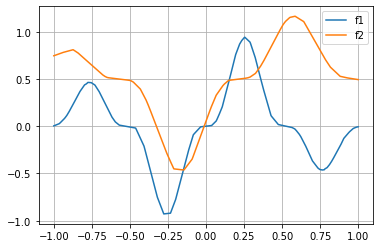

In [4]:
# Plot f1 and f2 in the same figure.
# Below is what the figure will look like.

bounds = torch.tensor([-1, 1])
xs = np.linspace(bounds[0], bounds[1], 1000)
xs = xs.reshape((1000, -1))
y1 = list(map(f1, xs))  # f1 to elements in xs 
y2 = list(map(f2,xs))  # f2 to elements in xs 
    
plt.plot(xs,y1, label = 'f1') 
plt.plot(xs,y2, label='f2')
plt.grid()
plt.legend()

plt.show()

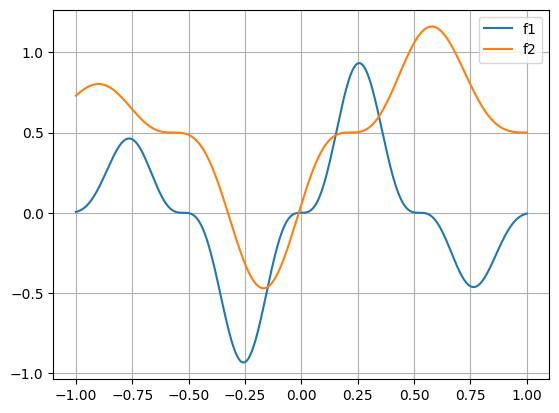

### 3. Setting up the Gaussian process and acquisition function

In [5]:
# Define a function as the main Bayesian Optimization loop of the multi-objective Bayesian Optimization.
# The input of the function: All x along with their observatioons from two objective functions.
# The output of the function: The next candidate x.

# generate_next_candidate(x, y):
#    Step 1. Define the Gaussian Process model for each objective, and maximize their Marginal Log Likelihood.
#    Step 2. Construct the multi-objective acquisition function (You can use qExpectedHypervolumeImprovement here.)
#    Step 3. Optimize the acquisition to find the next candidate x.
# return candidate

# Define your Gaussian Process model initialization function
def initialize_model(train_x, train_y):
    train_x = normalize(train_x, bounds)
    models = []
    for i in range(train_y.shape[-1]):
        train_objective = train_y[:, i]
      

        models.append(SingleTaskGP(train_x, train_objective.unsqueeze(-1)))
      
    model = ModelListGP(*models)
    return model

def generate_next_candidate(x, y):
    # Define and initialize the GP model
    model = initialize_model(x, y)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    # Optimize the model hyperparameters
    fit_gpytorch_model(mll)

    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([256]))

    train_x = normalize(x, bounds)

    partitioning = NondominatedPartitioning(ref_point=torch.FloatTensor([-1, -1]), Y=y)
    acq_fun = qExpectedHypervolumeImprovement(
        model=model,  # Pass your GP model here
        ref_point=torch.FloatTensor([-1, -1]),  # Define your reference point
        partitioning=partitioning,
        sampler=sampler
    )

    candidates, _ = optimize_acqf(
        acq_function=acq_fun,
        bounds = torch.stack([torch.zeros(1), torch.ones(1)]),  # Define your parameter bounds
        q=1,
        num_restarts=20,
        raw_samples=1024,
    )
    candidates = unnormalize(candidates, bounds)
    return candidates


### 4. Running Bayesian optimization

In [6]:
# Run the Multi-objective Bayesian Optimization
# Step 1. Generate initial x with their observations of the two objectives.
#         You can start with three x randomly generated within [-1,1].
# Step 2. Iteratively run the Multi-objective Bayesian Optimization on current training data to find new candidate,
#         and add the new candidate to your training data.
# Step 3. Please plot all the candiates and their observations of the two objectives at each iteration.

# Hint: Note that we aim to minimize the objective functions instead of maximize.

# Below are what all the figures look like.
# After 15 iterations an optimal has been reached around x = -0.2, which is in fact a zone where both functions reach minimum.

#STEP 1

def generate_initial_data(n_samples):
    x_init = torch.tensor(bounds[0]) + torch.rand(n_samples, 1) * (torch.tensor(bounds[1]) - torch.tensor(bounds[0])) # initial x 
    # y_init 
    finall = []       
    for xi in x_init:
        
        finall.append([f1(xi), f2(xi)])
        y_init = torch.tensor(finall)
    return x_init, y_init




In [7]:
#STEP 3 define plot candidate function 
def plot_candidates(candidates):
    xs = np.linspace(bounds[0], bounds[1], 1000)
    xs = xs.reshape((1000, -1))
    y1 = list(map(f1, xs)) 
    y2 = list(map(f2,xs))
    # plot of f1 and f2 
    plt.plot(xs,y1, label = 'f1') 
    plt.plot(xs,y2, label='f2')
    print(candidates)
    # plotting scatter plot for candidate values along f1 and f2
    plt.scatter(candidates[:, 0], candidates[:, 1], c='blue', label='Candidates')
    plt.scatter(candidates[:, 0], candidates[:, 2], c='orange', label='Candidates')
    plt.grid()
    
    plt.legend()
    plt.show()


tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568]])


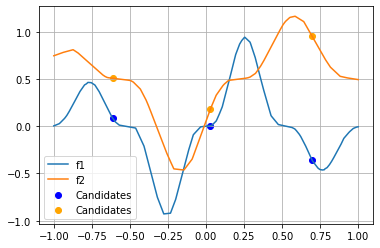

Iteration: 0
Candidates: tensor([[0.2654]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095]])


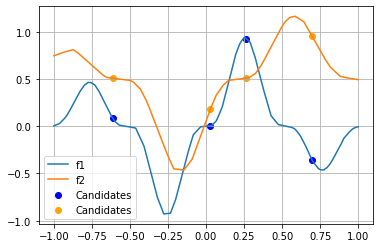

Iteration: 1
Candidates: tensor([[-0.2290]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889]])


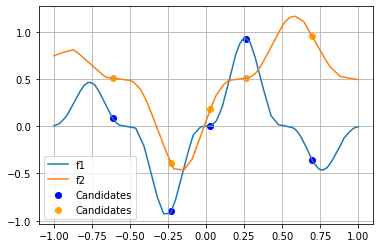

Iteration: 2
Candidates: tensor([[-0.2756]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111]])


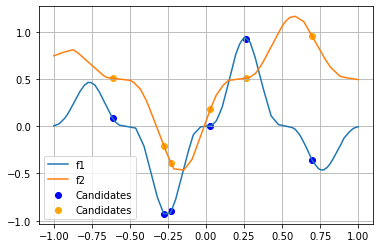

Iteration: 3
Candidates: tensor([[1.]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938]])


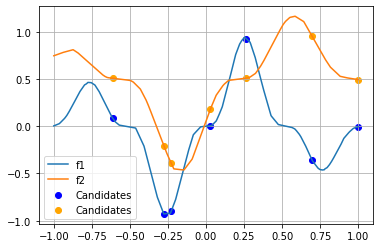

Iteration: 4
Candidates: tensor([[-0.2962]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255]])


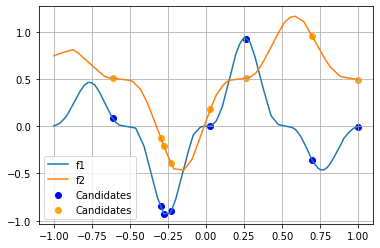

Iteration: 5
Candidates: tensor([[-0.1761]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584]])


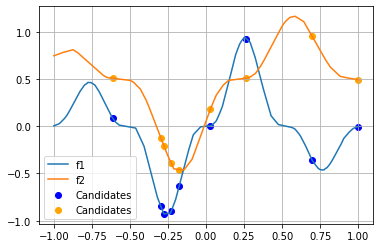

Iteration: 6
Candidates: tensor([[-1.]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459]])


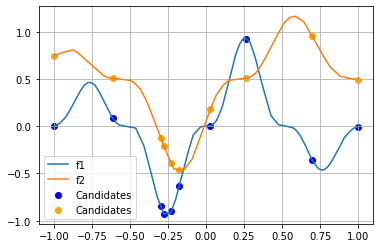

Iteration: 7
Candidates: tensor([[-0.2551]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459],
        [-0.2551, -0.9243, -0.2945]])


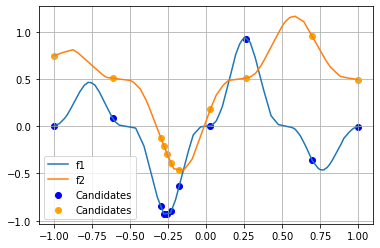

Iteration: 8
Candidates: tensor([[-0.2553]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459],
        [-0.2551, -0.9243, -0.2945],
        [-0.2553, -0.9244, -0.2936]])


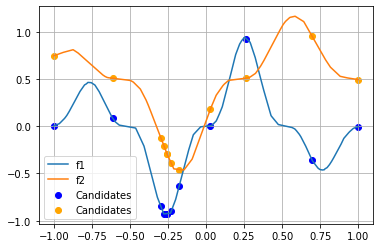

Iteration: 9
Candidates: tensor([[-0.1866]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459],
        [-0.2551, -0.9243, -0.2945],
        [-0.2553, -0.9244, -0.2936],
        [-0.1866, -0.6971, -0.4562]])


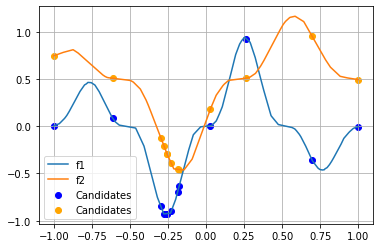

Iteration: 10
Candidates: tensor([[-0.2554]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459],
        [-0.2551, -0.9243, -0.2945],
        [-0.2553, -0.9244, -0.2936],
        [-0.1866, -0.6971, -0.4562],
        [-0.2554, -0.9244, -0.2933]])


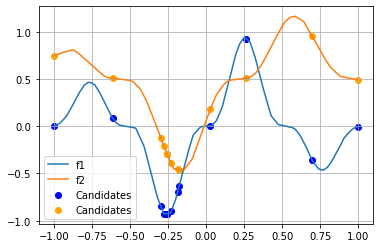

Iteration: 11
Candidates: tensor([[-0.1721]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459],
        [-0.2551, -0.9243, -0.2945],
        [-0.2553, -0.9244, -0.2936],
        [-0.1866, -0.6971, -0.4562],
        [-0.2554, -0.9244, -0.2933],
        [-0.1721, -0.6072, -0.4592]])


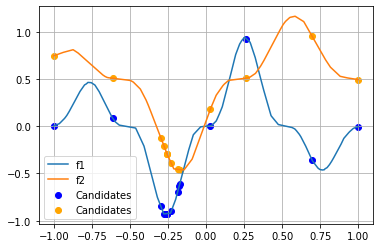

Iteration: 12
Candidates: tensor([[-0.2079]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459],
        [-0.2551, -0.9243, -0.2945],
        [-0.2553, -0.9244, -0.2936],
        [-0.1866, -0.6971, -0.4562],
        [-0.2554, -0.9244, -0.2933],
        [-0.1721, -0.6072, -0.4592],
        [-0.2079, -0.8138, -0.4519]])


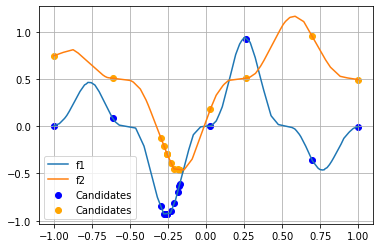

Iteration: 13
Candidates: tensor([[-0.1825]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459],
        [-0.2551, -0.9243, -0.2945],
        [-0.2553, -0.9244, -0.2936],
        [-0.1866, -0.6971, -0.4562],
        [-0.2554, -0.9244, -0.2933],
        [-0.1721, -0.6072, -0.4592],
        [-0.2079, -0.8138, -0.4519],
        [-0.1825, -0.6716, -0.4571]])


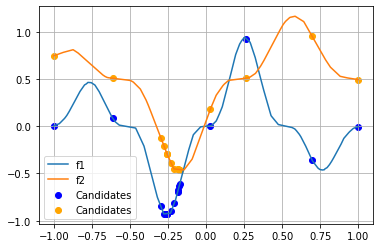

Iteration: 14
Candidates: tensor([[-0.1821]])
tensor([[-0.6121,  0.0836,  0.5081],
        [ 0.0287,  0.0059,  0.1793],
        [ 0.6956, -0.3529,  0.9568],
        [ 0.2654,  0.9266,  0.5095],
        [-0.2290, -0.9024, -0.3889],
        [-0.2756, -0.9278, -0.2111],
        [ 1.0000, -0.0057,  0.4938],
        [-0.2962, -0.8490, -0.1255],
        [-0.1761, -0.6321, -0.4584],
        [-1.0000,  0.0037,  0.7459],
        [-0.2551, -0.9243, -0.2945],
        [-0.2553, -0.9244, -0.2936],
        [-0.1866, -0.6971, -0.4562],
        [-0.2554, -0.9244, -0.2933],
        [-0.1721, -0.6072, -0.4592],
        [-0.2079, -0.8138, -0.4519],
        [-0.1825, -0.6716, -0.4571],
        [-0.1821, -0.6690, -0.4571]])


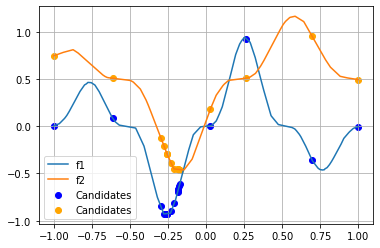

In [8]:
# STEP 2
n_iter = 15
n_start = 3

x, y = generate_initial_data(n_start)
plot_candidates(torch.cat([x,y], dim=1))


for i in range(n_iter):
    print(f"Iteration: {i}")
    
    candidates =  generate_next_candidate(x, -y)
    print(f"Candidates: {candidates}")
    x = torch.cat([x,candidates])
    k = torch.tensor([[f1(candidates), f2(candidates)]])
    y = torch.cat([y, k], dim=0)
    plot_candidates(torch.cat([x,y], dim=1)) # Calling plot candidates for initial data 



### 5. Examining the Pareto front

In [9]:
print(candidates)

   

tensor([[-0.1821]])


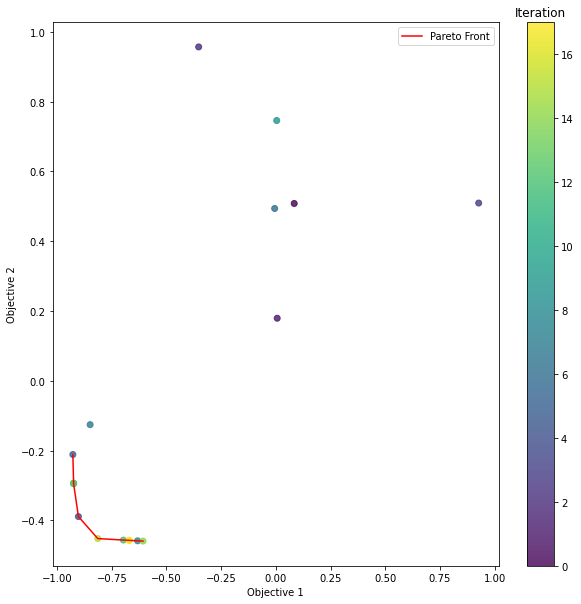

In [10]:
# Plot the value of objective f1 and objective f2 of all candiates, and mark the pareto front.
# Below is what the figure looks like.
# from botorch.utils.multi_objective.pareto import is_non_dominated can be useful.
from botorch.utils.multi_objective.pareto import is_non_dominated
from matplotlib.cm import ScalarMappable
import matplotlib.pyplot as plt

y_sorted = y[y[:, 0].sort()[1]]

# Calculate non dominant pairs to find and plot Pareto Front
pareto_front_x = []
pareto_front_y = []
non_dominated = is_non_dominated(-y_sorted)

for i, _y in enumerate(y_sorted):
    if non_dominated[i]:
        pareto_front_x.append(_y[0].item())
        pareto_front_y.append(_y[1].item())

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot of  Pareto Front
ax.plot(pareto_front_x, pareto_front_y, label="Pareto Front", c="r")

# Scatter plot with colormap based on the iteration from the for loop
iterations = list(range(len(y_sorted)))
sc = ax.scatter(y[:, 0], y[:, 1], c=iterations, alpha=0.8)
cbar = plt.colorbar(sc)
cbar.ax.set_title("Iteration")

# Set labels
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.legend()

plt.show()

